## Import Library

In [1]:
import logging
from typing import Dict, Tuple
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import random
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, precision_score
from sklearn.model_selection import train_test_split
from kedro.extras.datasets.pickle import PickleDataSet
from sklearn.model_selection import GridSearchCV
import xmltodict
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import sklearn


## Load/Save Data (XML/CSV)

In [2]:
def _clean_name (cadena):
    
    cadena_str= str(cadena)
    cadena_str=cadena_str[26:]
    cadena_str = cadena_str.replace('}', '',1)
    cadena_str = cadena_str.replace('\'','')
    
    return cadena_str

In [3]:
def _cambiar_columnas(df):
    
    columnas=len(df.columns)
    i=0
    while (i<columnas):
        df = df.rename(columns={df.columns[i]:i})
        i=i+1
        
        
    return df

In [4]:
def load_from_xml (path):
    xml=open(path, encoding='ISO-8859-1')
    xmldict = xmltodict.parse(xml.read())
    df_enfermedades = pd.DataFrame()
    lista_enfer_sinto_prob=[]
    first_tree=xmldict["JDBOR"]["HPODisorderSetStatusList"]["HPODisorderSetStatus"]
    id=0
    for nodo in xmldict["JDBOR"]["HPODisorderSetStatusList"]["HPODisorderSetStatus"]:
     
        enfermedad=_clean_name(nodo["Disorder"]["Name"])
        sec_tree= nodo["Disorder"]["HPODisorderAssociationList"]
        if (len(sec_tree)==2):
            tam_sintomas=len(sec_tree["HPODisorderAssociation"])
            i=0
            registro_enfer_sinto_prob=[]
            while (i<tam_sintomas):
                registro_enfer_sinto_prob.append(enfermedad)
                registro_enfer_sinto_prob.append(id)
                registro_enfer_sinto_prob.append(sec_tree["HPODisorderAssociation"][i]["HPO"]["HPOTerm"])
                frecuencia=_clean_name(sec_tree["HPODisorderAssociation"][i]["HPOFrequency"]["Name"])
                registro_enfer_sinto_prob.append(frecuencia)
                lista_enfer_sinto_prob.append (registro_enfer_sinto_prob)
                registro_enfer_sinto_prob=[]
                i=i+1
        id=id+1
    df_enfermedades = pd.DataFrame(lista_enfer_sinto_prob)
    df_enfermedades = df_enfermedades.rename(columns={0:'Enfermedad',1:'Id_Enfermedad', 2:'Sintoma', 3:"Frecuencia"})
    
    return df_enfermedades        

In [5]:
def save_to_csv (data, path):
    data.to_csv(path, index=False)

In [6]:
def load_from_csv (path):
    data=pd.read_csv(path)
    return data   

## Exploratory Data Analysis (EDA)

In [189]:
def clean_data(data): 
    
    data=data.drop_duplicates()
    data=data.dropna()
    vc = data["Sintoma"].value_counts()
    vector=vc[vc < 50].index
    for a in vector:
        indexNames = data [ data["Sintoma"] == a ].index
        for b in indexNames:
            data.drop(b , inplace=True, axis=0)
  
    return data 

## Feature Engineering 

In [34]:
def selection_and_preparation_data(data):
    
    #data=data[(data['Frecuencia']=="Muy frecuente (99-80%)")]
    data=data[(data['Frecuencia']=="Muy frecuente (99-80%)") | (data['Frecuencia']=="Frecuente (79-30%)")]
    #data=data[(data['Frecuencia']=="Frecuente (79-30%)")]

        
    return data


In [194]:
def generate_data_train (data, repeticiones):
    
    sintomas=data.iloc[:,1]
    sintomas_sin_repe=sintomas.drop_duplicates()
    sintomas_sin_repe=sintomas_sin_repe.sort_values(ascending
                              = True)
    df_train=pd.DataFrame(columns=sintomas_sin_repe)
   # df_train.insert(0, 'Enfermedad', 0)
    #df_train.insert(0, 'id_Enfermedad', 0)
 
    
    data_agrupado = (data.groupby("Enfermedad")
         .agg({"Sintoma": np.array, "Frecuencia": np.array})
         .reset_index()
         )
    
    z=0
    j=0
    while (z<repeticiones):
    
  #  print ("entra")
        i=0
        for a in data_agrupado["Enfermedad"]:
           # print ("Enfermedad: ", a)
        #vector_enfermedad.append(a)
        #lista=[]
            lst = [0] * ((len(sintomas_sin_repe)))
           
            df_train.loc[len(df_train)] = lst
           # df_train["Enfermedad"][j]=a
            #df_train["id_Enfermedad"][j]=(i)
           
            pos=0
            for b in data_agrupado["Sintoma"][i]:
                valor_aleatorio = random.random()
                frecuencia=data_agrupado["Frecuencia"][i][pos]
            #    print ("frecuencia:", frecuencia)
                if (frecuencia=="Muy frecuente (99-80%)"):
             #       print (b)
              #      print ("es muy frecuente")
                    if (valor_aleatorio>0.4):
                        valor_entero=1
                    else:
                        valor_entero=0
                elif (frecuencia=="Frecuente (79-30%)"):
               #     print (b)
                #    print ("es frecuente")
                    if (valor_aleatorio>0.6):
                        valor_entero=1
                    else:
                        valor_entero=0
                df_train[b][j]=valor_entero
               
                pos=pos+1
            j=j+1
            i=i+1
        z=z+1
        print ("VUELTA: ", z)
        print ("Tamaño: ",j)
    return df_train      

## Train Data and Predict

In [10]:
def train_data (df_train):
    
    target=df_train["id_Enfermedad"]
   # data=data.drop (['Enfermedad'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(df_train,target)
    rf= RandomForestClassifier()
    rf.fit (X_train,y_train)
    #prediccion=rf.predict(X_test)
    
    return df_train,rf,target,X_test,y_test, X_train, y_train


In [11]:
#def rank (df_train,rf,X_test):
  #  predicciones = rf.predict_proba(X_test)
   # predicciones[:5, :]
   # df_rank = pd.DataFrame(data=predicciones, columns=['0', '1','2','3','4', '5', '6', '7', '8'])
   # df_rank['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
   # return df_rank

## Evaluate

In [12]:
def evaluate (classifier, X_test, y_test):

    y_pred=classifier.predict(X_test)
    probs=classifier.predict_proba(X_test) [:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    pres= precision_score (y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    
   # roc_auc = roc_auc_score(y_test,probs, multi_class='ovr')
    #auc = roc_auc_score(y_test, probs)
    print ("Accurancy: ", acc)
    print ("Precision: ", pres)
    print ("f1: ", f1)
    #print ("auc: ", auc)
    
   # fpr, tpr, threshols = roc_curve(y_test, probs)
   # plt.plot(fpr,tpr)
   # plt.xlabel('False positives rate')
   # plt.ylabel('True positives rate')
   # plt.gcf().set_size_inches(8,6)
   

## Notebook Main

In [190]:
df_EnfeySinto=load_from_xml("../data/01_raw/enfermedades.xml")

In [191]:
df_EnfeySinto

,Enfermedad,Id_Enfermedad,Sintoma,Frecuencia
0,Enfermedad de Alexander,0,Macrocephaly,Muy frecuente (99-80%)
1,Enfermedad de Alexander,0,Intellectual disability,Muy frecuente (99-80%)
2,Enfermedad de Alexander,0,Seizure,Muy frecuente (99-80%)
3,Enfermedad de Alexander,0,Spasticity,Muy frecuente (99-80%)
4,Enfermedad de Alexander,0,Agenesis of corpus callosum,Muy frecuente (99-80%)
...,...,...,...,...
112684,Nevo de cabello lanoso,4263,Brachydactyly,Ocasional (29-5%)
112685,Nevo de cabello lanoso,4263,Widely-spaced incisors,Ocasional (29-5%)
112686,Nevo de cabello lanoso,4263,Persistent pupillary membrane,Ocasional (29-5%)
112687,Nevo de cabello lanoso,4263,Enlarged vestibular aqueduct,Ocasional (29-5%)


In [335]:
print ("Después de filtrado por sintomas filas")
print ("Enfermedades: ", df_EnfeySinto["Enfermedad"].nunique())
print ("Sintomas: ", df_EnfeySinto["Sintoma"].nunique())
print ("Frecuencias: ", df_EnfeySinto["Frecuencia"].nunique())  

Después de filtrado por sintomas filas
Enfermedades:  4262
Sintomas:  8303
Frecuencias:  6


In [257]:
df_EnfeySinto_cleaned=clean_data(df_EnfeySinto)

In [258]:
print ("Después de filtrado por sintomas filas")
print ("Enfermedades: ", df_EnfeySinto_cleaned["Enfermedad"].nunique())
print ("Sintomas: ", df_EnfeySinto_cleaned["Sintoma"].nunique())
print ("Frecuencias: ", df_EnfeySinto_cleaned["Frecuencia"].nunique())  

Después de filtrado por sintomas filas
Enfermedades:  4014
Sintomas:  196
Frecuencias:  6


In [259]:
df_EnfeySinto_select=selection_and_preparation_data(df_EnfeySinto_cleaned)
df_EnfeySinto_select

,Enfermedad,Id_Enfermedad,Sintoma,Frecuencia
0,Enfermedad de Alexander,0,Macrocephaly,Muy frecuente (99-80%)
1,Enfermedad de Alexander,0,Intellectual disability,Muy frecuente (99-80%)
2,Enfermedad de Alexander,0,Seizure,Muy frecuente (99-80%)
3,Enfermedad de Alexander,0,Spasticity,Muy frecuente (99-80%)
4,Enfermedad de Alexander,0,Agenesis of corpus callosum,Muy frecuente (99-80%)
...,...,...,...,...
112572,Síndrome de trastornos de conducta-discapacida...,4259,Macrotia,Muy frecuente (99-80%)
112573,Síndrome de trastornos de conducta-discapacida...,4259,Intellectual disability,Muy frecuente (99-80%)
112648,Artrogriposis múltiple congénita miogénica aut...,4262,Hyporeflexia,Muy frecuente (99-80%)
112649,Artrogriposis múltiple congénita miogénica aut...,4262,Motor delay,Muy frecuente (99-80%)


In [260]:
  print ("Después de borrado filas, duplicates y NAN")
  print ("Enfermedades: ", df_EnfeySinto_select["Enfermedad"].nunique())
  print ("Sintomas: ", df_EnfeySinto_select["Sintoma"].nunique())
  print ("Frecuencias: ", df_EnfeySinto_select["Frecuencia"].nunique())  


Después de borrado filas, duplicates y NAN
Enfermedades:  2544
Sintomas:  196
Frecuencias:  1


In [261]:
df_EnfeySinto_select=df_EnfeySinto_select.drop("Id_Enfermedad", axis=1)
df_EnfeySinto_select

,Enfermedad,Sintoma,Frecuencia
0,Enfermedad de Alexander,Macrocephaly,Muy frecuente (99-80%)
1,Enfermedad de Alexander,Intellectual disability,Muy frecuente (99-80%)
2,Enfermedad de Alexander,Seizure,Muy frecuente (99-80%)
3,Enfermedad de Alexander,Spasticity,Muy frecuente (99-80%)
4,Enfermedad de Alexander,Agenesis of corpus callosum,Muy frecuente (99-80%)
...,...,...,...
112572,Síndrome de trastornos de conducta-discapacida...,Macrotia,Muy frecuente (99-80%)
112573,Síndrome de trastornos de conducta-discapacida...,Intellectual disability,Muy frecuente (99-80%)
112648,Artrogriposis múltiple congénita miogénica aut...,Hyporeflexia,Muy frecuente (99-80%)
112649,Artrogriposis múltiple congénita miogénica aut...,Motor delay,Muy frecuente (99-80%)


In [262]:
%%time
df_train_generated=generate_data_train (df_EnfeySinto_select, 1)

VUELTA:  1
Tamaño:  2544
CPU times: user 1.78 s, sys: 7.23 ms, total: 1.79 s
Wall time: 1.79 s


In [263]:
df_train_generated.shape

(2544, 196)

In [264]:
df_Sintomas=df_EnfeySinto_select.groupby (["Sintoma"]).count().reset_index()


In [265]:
df_Sintomas=df_Sintomas.drop(["Enfermedad","Frecuencia"], axis=1)

In [266]:
df_Sintomas.head(50)

,Sintoma
0,Abdominal pain
1,Abnormal blistering of the skin
2,Abnormal facial shape
3,Abnormal heart morphology
4,Abnormal pyramidal sign
5,Abnormality of the dentition
6,Abnormality of the eye
7,Abnormality of the nervous system
8,Absent speech
9,Agenesis of corpus callosum


In [267]:
df_Sintomas[df_Sintomas["Sintoma"]=="Hypotonia"]

,Sintoma
100,Hypotonia


In [268]:
df_Enfermedades=df_EnfeySinto_select.groupby (["Enfermedad"]).count().reset_index()
df_Enfermedades=df_Enfermedades.drop(["Sintoma","Frecuencia"], axis=1)

In [269]:
df_Enfermedades=df_Enfermedades.reset_index()

In [270]:
df_Enfermedades.head(50)

,index,Enfermedad
0,0,AICA ribosiduria
1,1,ALG1-CDG
2,2,ALG11-CDG
3,3,ALG3-CDG
4,4,ALG8-CDG
5,5,ALG9-CDG
6,6,Abetalipoproteinemia
7,7,Acalasia idiopática
8,8,Aceruloplasminemia
9,9,Acidemia isovalérica


In [271]:
df_EnfeySinto_select[df_EnfeySinto_select["Enfermedad"]=="ALG8-CDG"] 


,Enfermedad,Sintoma,Frecuencia
29830,ALG8-CDG,Abnormality of the nervous system,Muy frecuente (99-80%)
29831,ALG8-CDG,Hypotonia,Muy frecuente (99-80%)
29832,ALG8-CDG,Abnormal facial shape,Muy frecuente (99-80%)


In [272]:
df_train_generated=_cambiar_columnas(df_train_generated)


In [273]:
df_train_generated


Sintoma,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2541,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [274]:
df_matrix=df_train_generated.transpose()

In [275]:
df_matrix

,0,1,2,3,4,5,6,7,8,9,...,2534,2535,2536,2537,2538,2539,2540,2541,2542,2543
Sintoma,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [276]:
ratings = df_matrix.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 1.16%


In [277]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2, shuffle=False, random_state=42)


In [278]:
ratings_train.shape, ratings_test.shape


((156, 2544), (40, 2544))

In [279]:

n_enfermedades = ratings_train.shape[1]
n_enfermedades
neighbors = NearestNeighbors(n_neighbors=20,
                         metric='cosine')
neighbors.fit(ratings_train)

NearestNeighbors(metric='cosine', n_neighbors=20)

In [280]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)
top_k_distances.shape

(156, 20)

In [336]:
#USUARIO_EJEMPLO = 'jbagnato' # debe existir en nuestro dataset de train!
#data = df_users[df_users['username'] == USUARIO_EJEMPLO]
SINTOMA_EJEMPLO = 'Cerebral cortical atrophy' # debe existir en nuestro dataset de train!
data = df_Sintomas[df_Sintomas['Sintoma'] == SINTOMA_EJEMPLO]
data

,Sintoma
34,Cerebral cortical atrophy


In [337]:
#sintoma_ver = (data.iloc[0]['Sintoma']) -1 # resta 1 para obtener el index de pandas
sintoma_ver= data.index
sintoma_ver=sintoma_ver.values[0]
sintoma_ver

34

In [313]:
top_k_distances[sintoma_ver]

array([0.        , 0.75381702, 0.88603942, 0.9163758 , 0.9163758 ,
       0.93571757, 0.94669982, 0.95454545, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [314]:
top_k_users.shape

(156, 20)

In [315]:
res = top_k_users[sintoma_ver]
res

array([ 44,  35, 114,  16,  61, 132,  12,  72, 107, 115, 111, 113, 101,
       106, 112, 104, 103, 102, 105, 110])

In [316]:
for a_index in res:
    print(df_Enfermedades[df_Enfermedades['index'] == (a_index)])

    index                 Enfermedad
44     44  Adenocarcinoma de esófago
    index                   Enfermedad
35     35  Acrodermatitis enteropática
     index                                         Enfermedad
114    114  Aplasia de los músculos extensores de los dedo...
    index                                         Enfermedad
16     16  Acidemia metilmalónica sensible a la vitamina B12
    index                                       Enfermedad
61     61  Albinismo ocular recesivo ligado al cromosoma X
     index    Enfermedad
132    132  Aspergilosis
    index                                         Enfermedad
12     12  Acidemia metilmalónica con homocistinuria tipo...
    index                               Enfermedad
72     72  Alfa-talasemia-síndrome mielodisplásico
     index                                         Enfermedad
107    107  Anomalía de los tendones extensores de los ded...
     index                              Enfermedad
115    115  Aplasia mulleriana e hi

In [306]:
df_EnfeySinto_select[df_EnfeySinto_select["Enfermedad"]=="Síndrome de Smith-Lemli-Opitz"] 

,Enfermedad,Sintoma,Frecuencia
25199,Síndrome de Smith-Lemli-Opitz,Microcephaly,Muy frecuente (99-80%)
25203,Síndrome de Smith-Lemli-Opitz,Micrognathia,Muy frecuente (99-80%)
25206,Síndrome de Smith-Lemli-Opitz,Wide nasal bridge,Muy frecuente (99-80%)
25208,Síndrome de Smith-Lemli-Opitz,Anteverted nares,Muy frecuente (99-80%)
25233,Síndrome de Smith-Lemli-Opitz,Intellectual disability,Muy frecuente (99-80%)
25235,Síndrome de Smith-Lemli-Opitz,Hypotonia,Muy frecuente (99-80%)
25237,Síndrome de Smith-Lemli-Opitz,Global developmental delay,Muy frecuente (99-80%)
25240,Síndrome de Smith-Lemli-Opitz,Growth delay,Muy frecuente (99-80%)
25250,Síndrome de Smith-Lemli-Opitz,Gastroesophageal reflux,Muy frecuente (99-80%)
25265,Síndrome de Smith-Lemli-Opitz,Short stature,Muy frecuente (99-80%)


In [288]:
users_predicts_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]):# para cada usuario del conjunto de entrenamiento
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) 
    / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [289]:
users_predicts_k.shape

(156, 2544)

In [290]:

user0=users_predicts_k.argsort()[sintoma_ver][-4:]
# los tres con mayor puntaje en la predic para este usuario
# agrego 4 puesto que uno es mi propio repositorio
for aRepo in user0:
    selRepo = df_Enfermedades[df_Enfermedades['index'] == (aRepo)]
    print(selRepo['Enfermedad'], 'puntaje:', users_predicts_k[sintoma_ver][aRepo])

690    Enfermedad de músculo-ojo-cerebro
Name: Enfermedad, dtype: object puntaje: 4.671593208209703
1681    Síndrome de Smith-Lemli-Opitz
Name: Enfermedad, dtype: object puntaje: 4.677999332705303
1628    Síndrome de Pitt Hopkins
Name: Enfermedad, dtype: object puntaje: 4.695818633509006
2024    Síndrome de glabela prominente-microcefalia-hi...
Name: Enfermedad, dtype: object puntaje: 4.697410425050461


In [322]:
df_EnfeySinto_select[df_EnfeySinto_select["Enfermedad"]=="Enfermedad por anticuerpos anti-membrana basal glomerular"] 

,Enfermedad,Sintoma,Frecuencia
8282,Enfermedad por anticuerpos anti-membrana basal...,Proteinuria,Muy frecuente (99-80%)
8287,Enfermedad por anticuerpos anti-membrana basal...,Anemia,Muy frecuente (99-80%)
8289,Enfermedad por anticuerpos anti-membrana basal...,Respiratory insufficiency,Muy frecuente (99-80%)
8294,Enfermedad por anticuerpos anti-membrana basal...,Autoimmunity,Muy frecuente (99-80%)
8297,Enfermedad por anticuerpos anti-membrana basal...,Cough,Muy frecuente (99-80%)
8298,Enfermedad por anticuerpos anti-membrana basal...,Chest pain,Muy frecuente (99-80%)


In [292]:
get_mse(users_predicts_k, ratings_train)


2.102976008577129

In [293]:
get_mse(users_predicts_k, ratings_test)


0.9126472455184712

In [294]:
#probamos con el otro


In [347]:
#USUARIO_EJEMPLO = 'jbagnato' # debe existir en nuestro dataset de train!
#data = df_users[df_users['username'] == USUARIO_EJEMPLO]
SINTOMA_EJEMPLO = 'Cerebral cortical atrophy' # debe existir en nuestro dataset de train!
data = df_Sintomas[df_Sintomas['Sintoma'] == SINTOMA_EJEMPLO]
data

,Sintoma
34,Cerebral cortical atrophy


In [348]:
#sintoma_ver = (data.iloc[0]['Sintoma']) -1 # resta 1 para obtener el index de pandas
sintoma_ver= data.index
sintoma_ver=sintoma_ver.values[0]
sintoma_ver

34

In [349]:

sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)

In [350]:
#separar las filas y columnas de train y test
sim_matrix_train = sim_matrix[0:156,0:156]
sim_matrix_test = sim_matrix[156:196,156:196]
print(sim_matrix_train.shape)
print(sim_matrix_test.shape)

(156, 156)
(40, 40)


In [351]:
users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T

In [356]:
user0=users_predictions.argsort()[sintoma_ver][-10:]
user0

array([1809, 2058, 1252,  419,   26, 2479, 1382, 1883, 2321, 2359])

In [359]:
#usuario_ver = data.iloc[0]['userId'] -1 # resta 1 para obtener el index de pandas

for i, aRepo in enumerate(user0[-10:]):
    print(aRepo)
    selRepo = df_Enfermedades[df_Enfermedades["index"]==aRepo]
    print (aRepo, sintoma_ver)
    print('Enfermedad:', selRepo["Enfermedad"] , 'scoring:', users_predictions[sintoma_ver][aRepo])
    
# Veamos los tres recomendados con mayor puntaje en la predic para este usuario


1809
1809 34
Enfermedad: 1809    Síndrome de atrofia cerebral difusa progresiva...
Name: Enfermedad, dtype: object scoring: 0.34546206122645734
2058
2058 34
Enfermedad: 2058    Síndrome de hipoplasia de la sustancia blanca-...
Name: Enfermedad, dtype: object scoring: 0.3458441298083368
1252
1252 34
Enfermedad: 1252    Secuencia disruptiva del cerebro fetal esporádica
Name: Enfermedad, dtype: object scoring: 0.35506609095917097
419
419 34
Enfermedad: 419    Disostosis acro-fronto-facio-nasal
Name: Enfermedad, dtype: object scoring: 0.36936764139283806
26
26 34
Enfermedad: 26    Aciduria mevalónica
Name: Enfermedad, dtype: object scoring: 0.37508634767430865
2479
2479 34
Enfermedad: 2479    Transposición penoescrotal
Name: Enfermedad, dtype: object scoring: 0.38906081766107053
1382
1382 34
Enfermedad: 1382    Síndrome de Angelman
Name: Enfermedad, dtype: object scoring: 0.4048073926266029
1883
1883 34
Enfermedad: 1883    Síndrome de deleción 1p36
Name: Enfermedad, dtype: object scoring: 

In [345]:
df_Enfermedades.shape

(2544, 2)

In [358]:
df_EnfeySinto_select[df_EnfeySinto_select["Enfermedad"]=="Disostosis acro-fronto-facio-nasal"]

,Enfermedad,Sintoma,Frecuencia
16293,Disostosis acro-fronto-facio-nasal,Cleft palate,Muy frecuente (99-80%)
16294,Disostosis acro-fronto-facio-nasal,High palate,Muy frecuente (99-80%)
16296,Disostosis acro-fronto-facio-nasal,Brachycephaly,Muy frecuente (99-80%)
16297,Disostosis acro-fronto-facio-nasal,Hypertelorism,Muy frecuente (99-80%)
16300,Disostosis acro-fronto-facio-nasal,Downslanted palpebral fissures,Muy frecuente (99-80%)
16301,Disostosis acro-fronto-facio-nasal,Ptosis,Muy frecuente (99-80%)
16305,Disostosis acro-fronto-facio-nasal,Brachydactyly,Muy frecuente (99-80%)
16307,Disostosis acro-fronto-facio-nasal,Cerebral cortical atrophy,Muy frecuente (99-80%)
16310,Disostosis acro-fronto-facio-nasal,Short stature,Muy frecuente (99-80%)
16313,Disostosis acro-fronto-facio-nasal,"Intellectual disability, severe",Muy frecuente (99-80%)


(array([ 80.,   0.,   0.,   0., 385.,   0.,   0.,   0., 166.,   0.,   0.,
          0.,  63.,   0.,   0.,   0.,  21.,   0.,   0.,   0.,  60.,   0.,
          0.,   0., 117.,   0.,   0.,   0.,  80.,   0.,   0.,   0.,  44.,
          0.,   0.,   0.,  57.,   0.,   0.,   0.,   0.,  51.,   0.,   0.,
          0.,  25.,   0.,   0.,   0.,  74.,   0.,   0.,   0.,  25.,   0.,
          0.,   0.,  62.,   0.,   0.,   0.,  64.,   0.,   0.,   0.,  59.,
          0.,   0.,   0., 359.,   0.,   0.,   0.,  46.,   0.,   0.,   0.,
         73.,   0.,   0.,   0.,   0.,  82.,   0.,   0.,   0., 100.,   0.,
          0.,   0.,  34.,   0.,   0.,   0.,  33.,   0.,   0.,   0., 183.,
          0.,   0.,   0.,  93.,   0.,   0.,   0., 118.,   0.,   0.,   0.,
         24.,   0.,   0.,   0., 113.,   0.,   0.,   0.,  84.,   0.,   0.,
          0.,   0.,  52.,   0.,   0.,   0.,  31.,   0.,   0.,   0.,  45.,
          0.,   0.,   0.,  45.,   0.,   0.,   0.,  41.,   0.,   0.,   0.,
         66.,   0.,   0.,   0.,  28., 

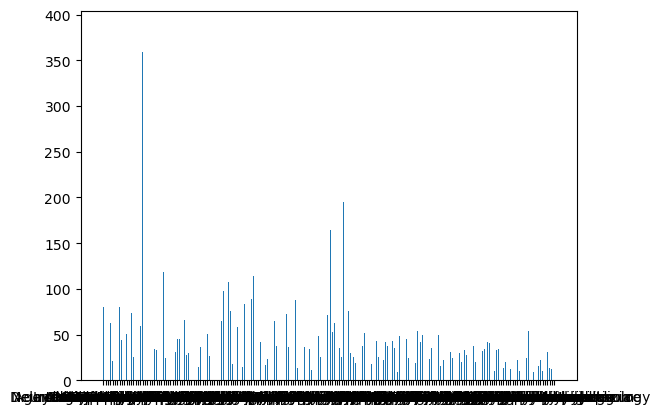

In [366]:
plt.hist(df_EnfeySinto_select.Sintoma,bins=800)

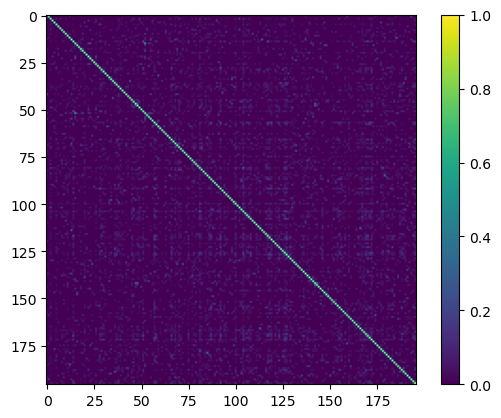

In [367]:

plt.imshow(sim_matrix);
plt.colorbar()
plt.show()

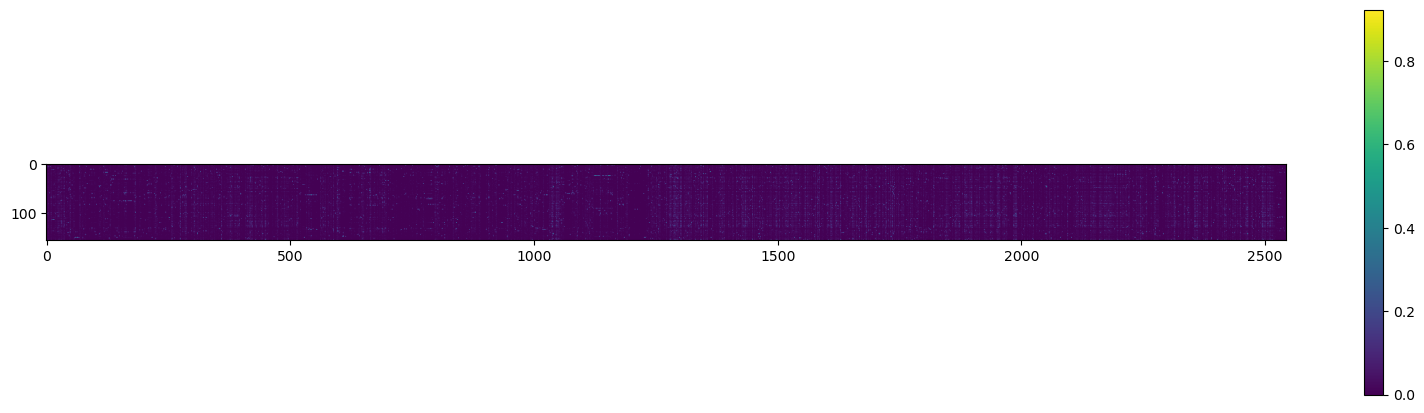

In [368]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

In [369]:

def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)
 


In [370]:
get_mse(users_predictions, ratings_train)
 


0.455185243370508

In [372]:
# Realizo las predicciones para el test set
users_predictions_test = sim_matrix.dot(ratings) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions_test = users_predictions_test[156:196,:]
 
get_mse(users_predictions_test, ratings_test)

0.5302801943238877

In [ ]:
ratings

In [ ]:
df_Sintomas

In [ ]:
save_to_csv(df_train_generated,"../data/01_raw/df_trained_Ofi.csv")

In [ ]:
#df_train_generated=pd.read_csv("../data/01_raw/df_trained_Ofi.csv")

In [ ]:
df_enfermedades= load_from_csv("../data/01_raw/exportCSVfromXML_Ofi.csv")

In [ ]:
save_to_csv(df_enfermedades,"../data/01_raw/exportCSVfromXML_Ofi.csv")

In [ ]:


sim_matrix.shape

In [ ]:

plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(sim_matrix);
plt.colorbar()
plt.show()

In [ ]:
sim_matrix_train

In [ ]:
users_predictions.shape

In [ ]:
ratings_train

In [ ]:

plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

In [ ]:
df_Enfermedades

In [ ]:
df_Sintomas.drop (["Enfermedad", "Frecuencia", "Id_Enfermedad"], axis=1)

In [ ]:
user0=users_predictions.argsort()[sintoma_ver]
user0

In [ ]:
rows=df_matrix.index
rows[sintoma_ver]

In [ ]:
df_matrix.iloc["id"]

In [ ]:
df_enfermedades_select[(df_enfermedades_select["Sintoma"]==SINTOMA_EJEMPLO) &
               (df_enfermedades_select["Enfermedad"]=="Aciduria 3-metilglutacónica tipo 1")]

In [ ]:
df_enfermedades_select

In [ ]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)
top_k_distances.shape

In [ ]:
data = df_repos[df_repos['title'] == 'jbagnato / machine-learning']
repo_ver = data.iloc[0]['repoId'] -1
#print(repo_ver)

In [ ]:
SINTOMA_EJEMPLO = 'Ataxia' # debe existir en nuestro dataset de train!
data = df_Sintomas[df_Sintomas['Sintoma'] == SINTOMA_EJEMPLO]
data.iloc[0]
sintoma_ver= data.index
sintoma_ver=sintoma_ver.values[0]
sintoma_ver

In [ ]:
df_Sintomas[df_Sintomas['repoId'].isin([sintoma_ver])]


In [ ]:
sintoma_ver= data.index
sintoma_ver=sintoma_ver.values[0]
sintoma_ver

In [ ]:
item_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

In [360]:
def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [361]:
get_mse(users_predictions, ratings_train)

0.455185243370508

In [362]:
# Realizo las predicciones para el test set
users_predictions_test = sim_matrix.dot(ratings) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions_test = users_predictions_test[50:63,:]

get_mse(users_predictions_test, ratings_test)

IndexError: index 13 is out of bounds for axis 0 with size 13

In [ ]:
neighbors = NearestNeighbors(1, 'cosine')
neighbors.fit(ratings_train.T)

In [ ]:
df_train_generated,model,target,X_test,y_test, X_train, y_train=train_data (df_train_generated)  

In [ ]:
evaluate (model, X_test, y_test)

model

In [ ]:
model

In [ ]:
import pickle

#pickle.dump(model,open("modelo19m.pickle","wb"))
model2=pickle.load(open("modelo19m.pickle","rb"))

In [ ]:
df_train_generated.to_csv("df_train_final.csv", index=False)

In [ ]:
from joblib import dump
dump(model, 'modelo19m.joblib') 

In [ ]:
from joblib import load
new_model = load('modelo19m.joblib')

In [ ]:
evaluate (new_model, X_test, y_test)

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

In [ ]:
X_test

In [ ]:
X_test.iloc[[1]]

In [ ]:
model.predict(X_test.iloc[[2]])

In [ ]:
y_test.iloc[[2]]

In [ ]:
predicciones = model.predict_proba(X_test.iloc[[2]])
predicciones.shape


In [ ]:
X_test.iloc[[2]]


In [ ]:
a=df_train_generated.columns


In [ ]:
b=a.to_list()
b.remove('id_Enfermedad')
b

In [ ]:
df_train_generated.columns
df_predicciones = pd.DataFrame(data=predicciones)
#df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones

In [ ]:
df_predicciones2=df_predicciones.transpose()
df_predicciones2

In [ ]:
list_to_rank=df_predicciones2[df_predicciones2[0]>0]

In [ ]:
rank = list_to_rank.sort_values(0,ascending=False)
rank

In [ ]:
rank2=rank.reset_index()

In [ ]:
rank2=rank2.head(5)
rank2

In [ ]:
rank2.merge (data)

In [ ]:
rank2["Enfermedad"]= rank2.apply(lambda row:
                                 data[data['Id_Enfermedad']==row["index"]].iloc[0][0]
                                 if data['Id_Enfermedad']==row["index"]
                                 else 0,
                                 axis=1
                                )

In [ ]:
data.iloc[0][0]

In [ ]:
for i in range(1):
    
    a=data[data['Id_Enfermedad']==rank2["index"][i]].iloc[0][0]
    a

In [ ]:
a

In [ ]:
a.iloc[0][0]

In [ ]:
list_rank=rank.to_numpy().tolist()
list_rank


In [ ]:
for i in range(5):
    print (i)
    print (lis)
        

In [ ]:
data[data['Id_Enfermedad']==2389]

#### 